In [1]:
!pip install -U google-genai

In [3]:
!ls drive/Shareddrives/LLM\ MP

'Datasets - Human-Labeled Validation Set.csv'  'Untitled document.gdoc'
'Datasets - Training.csv'		        wiktionary_en.csv
 Untitled0.ipynb			        wiktionary_tl.csv


In [15]:
import os
import json
from google import genai
from google.genai import types
from google.colab import userdata
from pydantic import BaseModel, Field

# --- Pydantic Model for Structured Output ---
# Define the exact structure you want the model's final answer to conform to.
class WeatherAndOutfit(BaseModel):
    """A class to hold the weather data and an outfit suggestion."""
    city: str = Field(description="The city for the weather forecast.")
    temperature: int = Field(description="The temperature in Celsius.")
    condition: str = Field(description="The weather condition (e.g., 'partly cloudy').")
    outfit_suggestion: str = Field(description="The recommended outfit based on the weather.")
    summary: str = Field(description="A short, human-readable summary of the weather and outfit advice.")

client = genai.Client(api_key=userdata.get("GEMINI_API_KEY"))
turn = 0
# ---- Tools ----
def get_weather(city: str):
    print(turn, city)
    # Dummy implementation
    return {"city": city, "temp_c": 21, "condition": "partly cloudy"}

def suggest_outfit(temp_c: float, condition: str):
    print(turn, temp_c, condition)
    # Dummy implementation
    if temp_c < 10:
        return {"outfit": "heavy coat, scarf, and boots"}
    elif temp_c < 20:
        return {"outfit": "light jacket and jeans"}
    else:
        return {"outfit": "t-shirt and shorts"}

# ---- Tool schemas ----
weather_fn = types.FunctionDeclaration(
    name="get_weather",
    description="Get the current weather for a city",
    parameters=types.Schema(
        type="OBJECT",
        properties={"city": types.Schema(type="STRING")},
        required=["city"],
    ),
)
outfit_fn = types.FunctionDeclaration(
    name="suggest_outfit",
    description="Suggest what to wear given temperature and condition",
    parameters=types.Schema(
        type="OBJECT",
        properties={
            "temp_c": types.Schema(type="NUMBER"),
            "condition": types.Schema(type="STRING"),
        },
        required=["temp_c", "condition"],
    ),
)
tools = [types.Tool(function_declarations=[weather_fn, outfit_fn])]

# ---- Conversation state ----
messages = [
    types.Content(role="user", parts=[types.Part.from_text(
        text="What's the weather in Boston, and what should I wear?"
    )])
]

model_name = "gemini-2.5-flash"

# ---- Loop until no function calls ----
while True:
    turn += 1
    resp = client.models.generate_content(
        model=model_name,
        contents=messages,
        config=types.GenerateContentConfig(
            tools=tools,
            temperature=0,
            top_p=0,
            top_k=1,
		        # response_schema=WeatherAndOutfit,
		        # response_mime_type="application/json",
        ),
    )

    if not resp.function_calls:
        # Model gave final answer
        messages.append(resp.candidates[0].content)
        print("Assistant:", resp.text)
        break

    # Handle each function call
    for fc in resp.function_calls:
        args = fc.args if not isinstance(fc.args, str) else json.loads(fc.args)

        if fc.name == "get_weather":
            result = get_weather(**args)
        elif fc.name == "suggest_outfit":
            result = suggest_outfit(**args)
        else:
            result = {"error": f"Unknown function {fc.name}"}

        # Append the function call and response to conversation
        messages.append(resp.candidates[0].content)  # model's function-call message
        messages.append(
            types.Content(
                role="tool",
                parts=[types.Part.from_function_response(name=fc.name, response=result)],
            )
        )

1 Boston
2 21 partly cloudy


Assistant: The weather in Boston is partly cloudy with a temperature of 21°C. You should wear a t-shirt and shorts.


In [14]:
for message in messages:
  print(f"role: {message.role}")
  # Check if the message has text parts
  if message.parts and message.parts[0].text:
    print(f"text: {message.parts[0].text}")
  print("-" * 20)

role: user
text: What's the weather in Boston, and what should I wear?
--------------------
role: model
--------------------
role: tool
--------------------
role: model
--------------------
role: tool
--------------------
role: model
text: The weather in Boston is partly cloudy with a temperature of 21°C. You should wear a t-shirt and shorts.
--------------------


In [74]:
import os
import json
from google import genai
from google.genai import types
from google.colab import userdata

client = genai.Client(api_key=userdata.get("GEMINI_API_KEY"))
turn = 0

In [75]:
import pandas as pd
train_df = pd.read_csv('drive/Shareddrives/LLM MP/Datasets - Training.csv')[1:]
# shuffle
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
# train_df

In [76]:
eval_df = pd.read_csv('drive/Shareddrives/LLM MP/Datasets - Human-Labeled Validation Set.csv')
# rename 'Final Score                          (1 - lowest, 5 - highest)' to Final Score, Source Text (English) to English, Target Text (Filipino) to Filipino
eval_df = eval_df.rename(columns={'Final Score                          (1 - lowest, 5 - highest)': 'Final Score', 'Source Text (English)': 'English', 'Target Text (Filipino)': 'Filipino'})
eval_df = eval_df.dropna(subset=['Final Score'])
# eval_df

In [77]:
from pydantic import BaseModel, Field
from typing import Literal
class Criteria(BaseModel):
	"""A class to hold the analysis, comment, and type for a specific criterion."""
	analysis: str = Field(description="The analysis of the segment or document.")
	comment: str = Field(
		description="A clear and concise comment explaining the analysis and providing a corrected alternative."
	)
	type: Literal["Correct", "Minor", "Major"] = Field(
		description="The type for the analysis, one of 'Correct', 'Minor', or 'Major'."
	)
class TranslationEvaluation(BaseModel):
	"""A class to hold the translation evaluation results."""
	term_accuracy: Criteria = Field(
		description="Evaluation of term accuracy and consistency."
	)
	meaning_fidelity: Criteria = Field(
		description="Evaluation of meaning fidelity."
	)
	grammar_structure: Criteria = Field(
		description="Evaluation of grammar and structure."
	)
	style_naturalness: Criteria = Field(
		description="Evaluation of style and readability."
	)
	cultural_biases: Criteria = Field(
		description="Evaluation of cultural and audience fit."
	)
	analysis: str = Field(
		description="Overall analysis of the translation."
	)
	rating: int = Field(
		description="Overall rating of the translation, from 1 (incomprehensible) to 5 (perfect translation)."
	)

base_system_prompt = "You are an expert Filipino linguist."
base_prompt_template = """# Filipino Translation Evaluation

## Severity categories (how to mark each criterion)
Use one label for every criterion:
- **Correct (No Error)** — The translation is acceptable for the intended audience and purpose. No action required.
- **Minor** — Small problem that does not materially affect meaning or usability (e.g., awkward phrasing, minor grammatical slip, minor punctuation error). Fix recommended but not urgent.
- **Major** — Significant problem that seriously affects understandability, fidelity, or usability. This includes errors that change meaning, omit essential info, or are highly inappropriate for the audience.

---
## Evaluation criteria

### 1) Term Accuracy & Consistency
**Definition:** The correctness or accuracy of translations of terms (root words).

**Error Types:**
- **Inconsistent term use:** — inconsistent translations of the same term within the segment or document.
- **Incorrect terms:** Incorrect translations for words.
  _Break time_: **nasirang oras** (Major), **pahinga** (Minor, related meanings and may not significantly alter semantics, depending on context).
- **Technical / clinical / legal / jargon errors:** Poor handling of domain terms.
  _Glucose level_: **lebel ng asukal** (Major, alters meaning), **lebel ng glucose** (Minor, Glucose level may be preferred in medical contexts for clarity).
- **Names, numbers, and factual errors:** Misspelled place names or wrong proper nouns should be marked Major.
  _100_: **isang daan** (Correct, spelling variation), **isang libo** (Major)
  _Juan_: **John** (Major)
- **Spelling:** typographical or orthographic errors.

---

### 2) Meaning Fidelity
**Definition:** Faithfulness to the source message — no distortion, omission, or addition.

**Error Types:**
- **Mistranslation:** incorrect meaning conveyed.
- **Overtranslation / Addition:** extra information not in source.
- **Undertranslation / Omission:** missing information.
- **Loss of idiom, metaphor, tone or emotional weight:** euphemisms or humor that become flat — mark Minor or Major depending on whether meaning or tone is lost.

**Examples:**
- Source: "The medication is for temporary use." → **Major:** Permanenteng gamit ang gamot.
- Source: "Please sign here for a bit." →  "Pakilagda dito ng saglit" (Correct, for a bit is captured by saglit).

**Filipino-specific explanations & examples:**
- **Mistranslation of nuance / semantic flips:** In Filipino, verb focus (actor vs object) can change who performs an action. If translation flips focus and changes responsibility or intent, mark Major.
   Source: "We asked for help." → **Major:** "Hiningian kami ng tulong". (implies we are the ones who were asked, not the ones who asked)
- **Tense/aspect/focus errors:** Incorrect tense/voice (e.g., translating general truths as past events). Filipino is a morphologically complex language. Classify as Major if the error significantly alters semantics.

---

### 3) Grammar & Structure
**Definition:** Basic linguistic correctness and sentence formation.

**Error Types:**
- **Grammar:** wrong conjugation, incorrect syntax.
- **Punctuation:** missing/extra commas, incorrect use of quotation marks, spacing, incorrect capitalization.
- **Wrong affixation:** **magisip** (Minor) vs **mag-isip**/**mag isip** (Correct)
- **Missing or incorrect linkers:** Dropped or wrong "na", "ng", "nang" — mark Minor when purely grammatical, Major if meaning changes.

---

### 4) Style, Fluency, Naturalness
**Definition:** Is it culturally appropriate for Filipino readers?

**Error Types:**
- **Unnatural word order and grammatical constructions:** Overuse of _ay_ inversion or awkward inversions that sound non-native — usually Minor.
  A 4.8 magnitude earthquake hit yesterday → **Major:** Ang lindol na may lakas na 4.8 ay tumama kahapon. (ay inversion with unnatural word order, should be "Tumama ang magnitude 4.8 na lindol kahapon.")
- **Unnatural wording / awkward phrasing:** phrasing that sounds non-native or overly formal — usually Minor.
  I know what I know. → **Major:** Ang alam ko lang ay ang nalalaman ko. (unnatural ay inversion, unnatural wording of "ang nalalaman ko" for "what I know")
- **Tone mismatch:** Translations that are unnaturally stiff or too slangy compared to the source text, usually Minor for small tone slips.
- **Improper code-switching and inconsistent register:** Inappropriate mixing of English and Filipino that breaks tone, Minor.
- **Style / flow / readability issues:** Awkward phrasing or repetition — typically Minor, escalate to Major if it blocks comprehension.
- **Overly literal / word-for-word translation:** Mechanical renderings that ignore idiom (e.g., literal metaphors) — mark Minor or Major depending on whether meaning or tone is lost.

---

### 5) Cultural Biases
**Definition:** Use of culture-specific references, offensiveness, or language that won’t be understood by target audience.

**Error Types:**
- **Culture-specific reference:** literal carryover of source culture references that confuse readers.
- **Offensive:** translations that create unintended insult or culturally insensitive phrasing.
- **Localization & cultural insensitivity:** Poor choices for culturally loaded terms (incorrectly as a translation for Creator in a secular context), mistranslated place names or history facts — Major when sensitive.
- **Audience appropriateness:** Culture-specific references that the intended Filipino audience won't understand should be adapted or explained; rate Minor or Major based on impact.
- **Age / gender, Cultural (preferring Western values over Filipino norms):** Biases are present in the translation that are not originally in the source text.
  The nurse went outside. → **Major:** Lumabas ang babaeng nars. (Incorrectly assumed the female gender of the nurse, which is not specified in the source text.)

---

## Scoring & process guidance for raters
- Rate every criterion for the segment or document required by workflow.
- Correct if the entire translation is acceptable, Minor if there are slight issues, Major if at least one significant issue exists.
- When in doubt between Minor and Major, consider impact on user understanding or safety. If the issue could cause user harm, legal problems, or serious misinterpretation, mark Major.
- If the translation intentionally adapts content for target-culture relevance (and this behavior is allowed by brief), mark **Correct** and note the adaptation; do not penalize for acceptable localization.
- Provide a short comment for every rating explaining what is right/wrong and provide a corrected alternative (one sentence or a span suggestion).
- After evaluating all criteria, provide an overall analysis of the translation and a rating from 1 to 5:
  - **1**: Incomprehensible translation, major issues in most criteria.
  - **2**: Poor but somewhat understandable, major issues in some criteria.
  - **3**: Poor but understandable, minor issues in some criteria.
  - **4**: Good translation, minor issues in one or two criteria.
  - **5**: Acceptably correct translation, with no issues in any criteria.

---

# Output format
The output should be a JSON object that conforms to the `TranslationEvaluation` model. It should include detailed analysis, comments, and types for each evaluation criterion, as well as an overall analysis and rating.
Criteria format:
{
  "analysis": "Detailed analysis of the segment or document.",
  "comment": "A clear and concise comment explaining the analysis and providing a corrected alternative.",
  "type": "Correct" | "Minor" | "Major"
}
Output format:
{
  "term_accuracy": Criteria,
  "meaning_fidelity": Criteria,
  "grammar_structure": Criteria,
  "style_naturalness": Criteria,
  "cultural_biases": Criteria,
  "analysis": "Overall analysis of the translation.",
  "rating": 1 | 2 | 3 | 4 | 5
}

---

## Example Evaluation
English text: "Please be careful, the floor is wet."
Tagalog translation: "Maging maingat, ang sahig ay basa."

### Expected JSON Output:
{
  "term_accuracy": {
    "analysis": "The terms 'maingat' (careful), 'sahig' (floor), and 'basa' (wet) are all accurate.",
    "comment": "No correction needed.",
    "type": "Correct"
  },
  "meaning_fidelity": {
    "analysis": "The translation perfectly preserves the warning and meaning of the source text.",
    "comment": "No correction needed.",
    "type": "Correct"
  },
  "grammar_structure": {
    "analysis": "The grammar is correct and intelligible.",
    "comment": "No correction needed.",
    "type": "Correct"
  },
  "style_naturalness": {
    "analysis": "The phrase 'ang sahig ay basa' uses the 'ay' inversion, which is grammatically correct but slightly less natural than the alternative. The more common, natural-sounding construction is 'basa ang sahig'.",
    "comment": "The translation is acceptable, but a more natural phrasing would be: 'Mag-ingat, basa ang sahig.'",
    "type": "Minor"
  },
  "cultural_biases": {
    "analysis": "The warning is culturally appropriate and universally understood.",
    "comment": "No correction needed.",
    "type": "Correct"
  },
  "analysis": "The translation is very good and fully understandable. There is only a minor stylistic issue where the word order could be more natural for everyday Filipino speech, but this does not impact comprehension.",
  "rating": 4
}
---

Now, please evaluate the following translation segment based on the criteria above.
English text: {english_text}
Tagalog translation: {tagalog_translation}
"""

In [78]:
def evaluate_translation(english_text: str, tagalog_translation: str) -> TranslationEvaluation:
	"""Evaluate a Tagalog translation of an English text."""
	# Prepare the prompt with the provided texts
	prompt = base_prompt_template.replace(
		"{english_text}", english_text
  ).replace(
		"{tagalog_translation}", tagalog_translation
	)

	# Call the model to generate the evaluation
	response = client.models.generate_content(
		model="gemini-2.0-flash",
		contents=[
			types.Content(role="user", parts=[types.Part.from_text(text=prompt)])
		],
		config=types.GenerateContentConfig(
			temperature=0,
			top_p=0,
			top_k=1,
			system_instruction=base_system_prompt,
			response_schema=TranslationEvaluation,
			response_mime_type="application/json"
		)
	)

	# Parse and return the structured output
	return response.parsed

In [13]:
# # Randomly sample 100 rows from the training data
# sampled_train_df = train_df.sample(n=100, random_state=42)

# # Evaluate the 'Filipino-Flawed' translation for each sampled row
# sampled_train_df['flawed_evaluation'] = sampled_train_df.apply(
#     lambda row: evaluate_translation(row['English'], row['Filipino-Flawed']), axis=1
# )

# # Filter the sampled DataFrame to view rows where the predicted rating for the flawed translation is >= 3
# flawed_high_rating = sampled_train_df[
#     sampled_train_df['flawed_evaluation'].apply(lambda x: int(x.rating) >= 3)
# ]

# Display the filtered DataFrame
# display(flawed_high_rating[['English', 'Filipino-Flawed', 'flawed_evaluation', 'Remarks']])

In [7]:
# remove width limit of pd
pd.set_option('display.max_colwidth', None)

In [133]:
i = 0
english = train_df['English'].iloc[i]
tagalog = train_df['Filipino-Correct'].iloc[i]
res = evaluate_translation(english, tagalog)
print(english)
print(tagalog)
for key, value in res.model_dump().items():
    print(f"{key}: {value}")
print('----')
tagalog = train_df['Filipino-Flawed'].iloc[i]
res = evaluate_translation(english, tagalog)
print(english)
print(tagalog)
for key, value in res.model_dump().items():
    print(f"{key}: {value}")

Look at you, you're still here. Every time you say you want to quit, you're really just asking for help.
Tingnan mo ang sarili mo, nandito ka pa rin. Tuwing sinasabi mong gusto mong sumuko, ang totoo, humihingi ka lang ng tulong.
term_accuracy: {'analysis': "All key terms such as 'still here' (nandito ka pa rin), 'quit' (sumuko), and 'asking for help' (humihingi ka lang ng tulong) are accurately translated.", 'comment': 'No correction needed.', 'type': 'Correct'}
meaning_fidelity: {'analysis': "The translation accurately conveys the full meaning and intent of the source text, including the observation ('Look at you') and the underlying message about asking for help.", 'comment': 'No correction needed.', 'type': 'Correct'}
grammar_structure: {'analysis': "The grammar, syntax, and use of linkers (e.g., 'mong') are correct throughout the translation. Punctuation is also accurate.", 'comment': 'No correction needed.', 'type': 'Correct'}
style_readability: {'analysis': "The phrase 'Tingnan 

In [ ]:
evaluations = eval_df.apply(lambda row: evaluate_translation(row['English'], row['Filipino']), axis=1)
eval_df['predictions1'] = evaluations

In [80]:
from concurrent.futures import ThreadPoolExecutor
import threading
import os
from tqdm import tqdm  # optional progress bar

def _worker_thread(args):
    idx, (english, filipino) = args
    while True:
      try:
          res = evaluate_translation(english, filipino)
          break
      except Exception as e:
          print(e)
          continue
    return idx, res

def parallel_apply_threaded(df, max_workers=16, show_progress=False):
    items = list(enumerate(zip(df['English'].tolist(), df['Filipino'].tolist())))
    results = [None] * len(df)
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        if show_progress:
            for idx, res in tqdm(ex.map(_worker_thread, items), total=len(items)):
                results[idx] = res
        else:
            for idx, res in ex.map(_worker_thread, items):
                results[idx] = res
    df = df.copy()
    df['predictions1'] = results
    return df

In [81]:
for i in range(0, 10):
    print(f"Iteration {i+1}")
    eval_df = parallel_apply_threaded(eval_df, max_workers=100, show_progress=True)
    eval_df[f"predictions{i+1}"] = eval_df['predictions1']

Iteration 1


100%|██████████| 57/57 [00:03<00:00, 15.59it/s]


Iteration 2


100%|██████████| 57/57 [00:03<00:00, 15.30it/s]


Iteration 3


100%|██████████| 57/57 [00:04<00:00, 13.81it/s]


Iteration 4


100%|██████████| 57/57 [00:04<00:00, 14.12it/s]


Iteration 5


100%|██████████| 57/57 [00:03<00:00, 15.42it/s]


Iteration 6


100%|██████████| 57/57 [00:03<00:00, 14.94it/s]


Iteration 7


100%|██████████| 57/57 [00:03<00:00, 15.58it/s]


Iteration 8


100%|██████████| 57/57 [00:03<00:00, 14.53it/s]


Iteration 9


100%|██████████| 57/57 [00:03<00:00, 15.09it/s]


Iteration 10


100%|██████████| 57/57 [00:03<00:00, 14.54it/s]


In [110]:
pred_cols = [f"predictions{i}" for i in range(1, 11)]
pred_ratings = eval_df[pred_cols].applymap(lambda x: x.rating)
avg_row_std = pred_ratings.std(axis=1, ddof=0).mean()
print("avg_row_std:", avg_row_std)

avg_row_std: 0.033623072613880145


/tmp/ipython-input-1673451929.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pred_ratings = eval_df[pred_cols].applymap(lambda x: x.rating)


In [111]:
import numpy as np
mean_per_input = pred_ratings.mean(axis=1)
std_per_input  = pred_ratings.std(axis=1, ddof=0)   # population std (ddof=0). use ddof=1 if you prefer sample std
cv_per_input   = std_per_input / mean_per_input.replace(0, np.nan)  # avoid div-by-zero
rel_range_per_input = (pred_ratings.max(axis=1) - pred_ratings.min(axis=1)) / mean_per_input.replace(0, np.nan)

# 2) Dataset-level summaries
summary = {
    'mean_CV': cv_per_input.mean(),                     # average CV across inputs
    'median_CV': cv_per_input.median(),
    'pct_inputs_CV_lt_10pct': (cv_per_input < 0.10).mean(),   # fraction meeting your <10% target
    'mean_rel_range': rel_range_per_input.mean(),
    'pct_exact_same_rating': (std_per_input == 0).mean(),     # proportion of inputs with zero variation
    'overall_CV': pred_ratings.stack().std(ddof=0) / pred_ratings.stack().mean(),  # global CV
}

# 3) Attach the per-input metrics to the dataframe (optional)
per_input_df = pd.DataFrame({
    'mean': mean_per_input,
    'std': std_per_input,
    'cv': cv_per_input,
    'rel_range': rel_range_per_input,
})

print("Dataset summary:", summary)
per_input_df.head()

Dataset summary: {'mean_CV': np.float64(0.009661619052965762), 'median_CV': 0.0, 'pct_inputs_CV_lt_10pct': np.float64(0.9473684210526315), 'mean_rel_range': np.float64(0.020271667966297695), 'pct_exact_same_rating': np.float64(0.9298245614035088), 'overall_CV': np.float64(0.2098111607486714)}


,mean,std,cv,rel_range
0,4.0,0.0,0.0,0.0
1,5.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0
3,3.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0


In [86]:
import pandas as pd
from scipy.stats import pearsonr

# Assuming eval_df is your DataFrame
correlation, v = pearsonr(eval_df['predictions1'].apply(lambda x: int(x.rating)), eval_df['Final Score'])
print("Pearson's correlation coefficient:", correlation, v)

Pearson's correlation coefficient: 0.4611573976703768 0.00030588049804831436


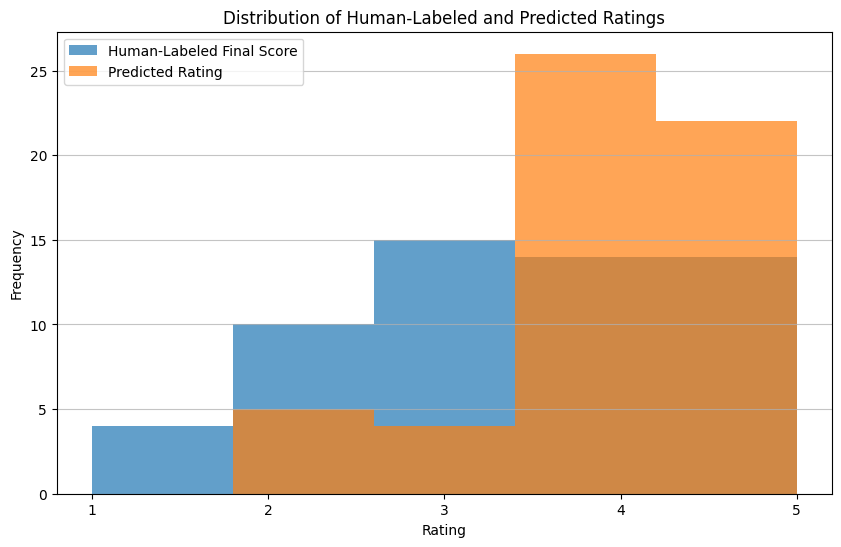

In [87]:
import matplotlib.pyplot as plt

# Plot histograms of Final Score and predicted_rating
plt.figure(figsize=(10, 6))
plt.hist(eval_df['Final Score'], bins=5, alpha=0.7, label='Human-Labeled Final Score', range=(1, 5))
plt.hist(eval_df['predictions1'].apply(lambda x: int(x.rating)), bins=5, alpha=0.7, label='Predicted Rating', range=(1, 5))
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Human-Labeled and Predicted Ratings')
plt.xticks(range(1, 6))
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

In [13]:
# Calculate the absolute difference between predicted and final scores
eval_df['rating_difference'] = abs(eval_df['predictions1'].apply(lambda x: int(x.rating)) - eval_df['Final Score'])

# Sort the DataFrame by the absolute difference in descending order
eval_df_sorted = eval_df.sort_values(by='rating_difference', ascending=False)

In [14]:
i=12
print(eval_df_sorted.iloc[i].English)
print(eval_df_sorted.iloc[i].Filipino)
for key, value in eval_df_sorted.iloc[i].predictions1.model_dump().items():
    print(f"{key}: {value}")

print(eval_df_sorted.iloc[i]['Final Score'])
print(eval_df_sorted.iloc[i]['Rater 1 Explanation'])
print(eval_df_sorted.iloc[i]['Rater 2 Explanation'])

After being checked up, you have to be admitted to the hospital for observation and treatment.
Pagkatapos ng check-up, kailangang ma-admit ka sa ospital para ma-obserbahan at gamutan.
term_accuracy: {'analysis': "The terms 'check-up', 'admit', and 'obserbahan' are borrowed English terms commonly used and understood in Filipino. 'Gamutan' is the correct Filipino term for treatment.", 'comment': 'No correction needed.', 'type': 'Correct'}
meaning_fidelity: {'analysis': 'The translation accurately conveys the meaning of the source text, including the sequence of events (check-up first, then admission) and the purpose of admission (observation and treatment).', 'comment': 'No correction needed.', 'type': 'Correct'}
grammar_structure: {'analysis': "The sentence structure is grammatically correct in Filipino. The use of 'Pagkatapos ng check-up' followed by the main clause is standard. The passive voice constructions ('ma-admit', 'ma-obserbahan') and the noun form 'gamutan' are correctly used

In [4]:
!pip install sacrebleu

In [15]:
# load wiktionary_tl
import pandas as pd
from ast import literal_eval
tmp = pd.read_csv('drive/Shareddrives/LLM MP/wiktionary_tl.csv')
tl_dictionary = {}
def extract_gloss_senses(row, dictionary=tl_dictionary):
	senses = literal_eval(row['senses'])
	word = row['word']
	ret = []
	for sense in senses:
		if 'glosses' not in sense or not sense['glosses']:
			continue
		ret.append('; '.join(sense['glosses']))
	if ret and (word not in dictionary or len(dictionary[word]) < len(ret)):
		dictionary[word] = ret
tmp.apply(lambda row: extract_gloss_senses(row, tl_dictionary), axis=1)
tmp = pd.read_csv('drive/Shareddrives/LLM MP/wiktionary_en.csv')
en_dictionary = {}
tmp.apply(lambda row: extract_gloss_senses(row, en_dictionary), axis=1)
del tmp
from typing import Dict
def dictionary_tool(word: str, lang: str="tl") -> Dict[str, str]:
	if lang == "tl":
		if word in tl_dictionary:
			return {"word": word, "definition": '\n\t'.join(tl_dictionary[word])}
		else:
			return {"error": "No definition found for {}.".format(word)}
	if lang == "en":
		if word in en_dictionary:
			return {"word": word, "definition": '\n\t'.join(en_dictionary[word])}
		else:
			return {"error": "No definition found for {}.".format(word)}
	return {"error": f"Language '{lang}' is not supported. Only 'tl' and 'en' are supported."}
# sacrebleu
import sacrebleu
def sacrebleu_tool(english_text: str, tagalog_translation: str) -> Dict[str, float]:
	"""Evaluate a Tagalog translation using sacreBLEU."""
	# Prepare the reference and hypothesis
	reference = [english_text]
	hypothesis = tagalog_translation

	# Calculate BLEU score
	bleu = sacrebleu.corpus_bleu(hypothesis, [reference])
	return {"score": bleu.score}

/tmp/ipython-input-3355287122.py:4: DtypeWarning: Columns (8,9,12,13,14,16,18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv('drive/Shareddrives/LLM MP/wiktionary_tl.csv')
/tmp/ipython-input-3355287122.py:17: DtypeWarning: Columns (9,19,26,27,28,29,30,31,32,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv('drive/Shareddrives/LLM MP/wiktionary_en.csv')


In [46]:
# ===== TRANSLATION EVALUATION AGENT SYSTEM =====
import os
import json
from google import genai
from google.genai import types
from pydantic import BaseModel, Field
from typing import Optional, Dict, Any
from typing import Literal
from collections import Counter
from google.colab import userdata

class Criteria(BaseModel):
	"""A class to hold the analysis, comment, and type for a specific criterion."""
	analysis: str = Field(description="The analysis of the segment or document.")
	type: Literal["Correct", "Minor", "Major"] = Field(
		description="The type for the analysis, one of 'Correct', 'Minor', or 'Major'."
	)
class TranslationEvaluation(BaseModel):
	"""A class to hold the translation evaluation results."""
	term_accuracy: Criteria = Field(description="Evaluation of term accuracy and consistency.")
	meaning_fidelity: Criteria = Field(description="Evaluation of meaning fidelity.")
	grammar_structure: Criteria = Field(description="Evaluation of grammar and structure.")
	style_naturalness: Criteria = Field(description="Evaluation of style and readability.")
	cultural_biases: Criteria = Field(description="Evaluation of cultural and audience fit.")
	analysis: str = Field(description="Overall analysis of the translation.")
	rating: int = Field(description="Overall rating of the translation, from 1 (incomprehensible) to 5 (perfect translation).")
# --- Pydantic Models for Structured Output ---
class SubAgentAnalysis(BaseModel):
	"""Output format for specialized sub-agents"""
	analysis: str = Field(description="Detailed analysis of the specific criterion")
	comment: str = Field(description="Clear comment with correction if needed")

class SelfEvaluationOutput(BaseModel):
	"""Output from self-evaluation agent"""
	accuracy_assessment: str = Field(description="Assessment of analyzer accuracy")
	needs_reevaluation: bool = Field(description="Whether re-evaluation is needed for the main analyzer")
	feedback_for_analyzer: Optional[str] = Field(description="Feedback to improve analysis")

# Initialize client
client = genai.Client(api_key=userdata.get("GEMINI_API_KEY"))

class TranslationEvaluationAgent:
	def __init__(self):
		self.model_name = "gemini-2.0-flash"
		self.turn = 0
		self.analyzer_state = []
		self.tools = []
		self.tool_stats = Counter()
		self.MAX_REEVALUATIONS = 5

	def analyze_translation(self, english_text: str, tagalog_translation: str) -> Dict[str, Any]:
		"""Main orchestration method"""
		self.turn = 0
		self.analyzer_state = None
		self.subagent_cache = {}
		num_repeats = 0
		while True:
			# Step 1: Main analyzer agent
			analyzer_result = self._run_analyzer_agent(english_text, tagalog_translation)

			data = self._run_extractor_agent(analyzer_result)
			subagent_results = self._get_subagent_results(english_text, tagalog_translation)
			# Step 3: Self-evaluation
			self_eval_result = self._run_self_evaluation(english_text, tagalog_translation, data, subagent_results)
			if not self_eval_result.needs_reevaluation or num_repeats >= self.MAX_REEVALUATIONS:
				break
			num_repeats += 1
			print("Re-evaluating: ", english_text, tagalog_translation, self_eval_result.feedback_for_analyzer)
			feedback = "Please re-evaluate the translation based on the feedback provided.\n\n" + self_eval_result.feedback_for_analyzer
			self.analyzer_state.append(
				types.Content(
					role="user",
					parts=[types.Part.from_text(text=feedback)]
				)
			)

		return {
			"final_evaluation": data,
			"self_evaluation": self_eval_result,
			"logs": self.analyzer_state,
			"subagemt_results": subagent_results
		}

	def _run_analyzer_agent(self, english_text: str, tagalog_translation: str) -> str:
		"""Main analyzer agent - simplified rubric evaluation"""
		system_prompt = """You are an expert Filipino linguist specializing in translation, and the main analyzer in an agentic system."""
		analyzer_prompt = """Evaluate a translation pair using these criteria:
1. Term Accuracy & Consistency - Are roots of terms translated correctly and consistently?
2. Meaning Fidelity - Does it preserve the source meaning faithfully? With no additions or omissions?
3. Grammar & Structure - Is it grammatically correct?
4. Style & Naturalness - Does it sound natural and appropriate?
5. Cultural & Audience Fit - Is it culturally appropriate for Filipino readers?

Your response must contain an analysis and a rating for each criterion.
- **Correct (No Error)** — The translation is acceptable for the intended audience and purpose. No action required.
- **Minor** — Small problem that does not materially affect meaning or usability (e.g., slightly-off terminology, awkward phrasing, minor grammatical slip, minor punctuation error). Fix recommended but not urgent.
- **Major** — Significant problem that seriously affects understandability, fidelity, or usability. This includes errors that change meaning, omit essential info, or are highly inappropriate for the audience.
Provide an overall analysis and rating (1-5), with 1 being incomprehensible, 3 being poor but understandable, and 5 being an acceptably correct translation.
You may call tools or ask for a detailed analysis from specialized sub-agents. You may also pass optional notes to sub-agents to give more context or analyze a specific aspect (no need to give the translation pair, the agent already has it).
"""

		tools = self._get_analyzer_tool_schemas()
		if not self.analyzer_state:
			self.analyzer_state = [
				types.Content(role="user", parts=[types.Part.from_text(
					text=analyzer_prompt + f"\n\nEnglish: {english_text}\nTagalog: {tagalog_translation}"
				)])
			]

		while True:
			self.turn += 1
			resp = client.models.generate_content(
				model=self.model_name,
				contents=self.analyzer_state,
				config=types.GenerateContentConfig(
					tools=tools,
            temperature=0,
            top_p=0,
            top_k=1,
					system_instruction=system_prompt,
				)
			)

			self.analyzer_state.append(resp.candidates[0].content)

			if not resp.function_calls:
				return resp.candidates[0].content.parts[0].text

			# Handle tool calls - collect all responses first
			tool_responses = []
			for fc in resp.function_calls:
				result = self._handle_tool_call(fc, english_text, tagalog_translation)
				tool_responses.append(
					types.Part.from_function_response(name=fc.name, response=result)
				)

			# Add all tool responses as a single content message
			self.analyzer_state.append(
				types.Content(
					role="tool",
					parts=tool_responses
				)
			)

	def _term_accuracy_agent(self, english_text: str, tagalog_translation: str, note: str) -> SubAgentAnalysis:
		"""Specialized agent for term accuracy evaluation"""
		note = 'Additional Notes: ' + note if note else ''
		system_prompt = """You are an expert Filipino linguist specializing in word translation."""
		prompt = f"""Focus on:
- Correct translations of specific terms
- Consistency within the text
- Technical/domain term handling
- Proper nouns and numbers
- Spelling accuracy

Examples:
- "Break time" → "nasirang oras" (Major error - wrong meaning), "pahinga" (Correct)
- "100" → "isang daan" (Correct), "isang libo" (Major error - wrong number)
- "Glucose level" → "lebel ng asukal" (Major error - wrong term), "lebel ng glucose" (Minor error - Glucose level may be preferred in medical contexts for clarity)

English: {english_text}
Tagalog: {tagalog_translation}
{note}
Analyze term accuracy and consistency specifically."""

		resp = client.models.generate_content(
			model=self.model_name,
			contents=[types.Content(role="user", parts=[types.Part.from_text(text=prompt)])],
			config=types.GenerateContentConfig(
            temperature=0,
            top_p=0,
            top_k=1,
				response_schema=SubAgentAnalysis,
				response_mime_type="application/json",
				system_instruction=system_prompt
			)
		)
		return resp.parsed

	def _meaning_fidelity_agent(self, english_text: str, tagalog_translation: str, note: str) -> SubAgentAnalysis:
		"""Specialized agent for meaning fidelity evaluation"""
		note = 'Additional Notes: ' + note if note else ''
		system_prompt = """You are an expert Filipino linguist specializing in translation analysis."""
		prompt = f"""Focus on:
- Accurate meaning preservation
- No additions or omissions
- Proper handling of idioms/metaphors
- Verb focus accuracy (actor vs object focus)
- Tense/aspect correctness

Examples:
- "We asked for help" → "Humingi kami ng tulong" (Correct) vs "Hiningian kami ng tulong" (Major error - wrong focus)
- "Please sign here for a bit" → "Pakilagda dito ng saglit" (Correct) vs "Pakilagda dito" (Major error - missing context)

English: {english_text}
Tagalog: {tagalog_translation}
{note}
Analyze meaning fidelity specifically."""

		resp = client.models.generate_content(
			model=self.model_name,
			contents=[types.Content(role="user", parts=[types.Part.from_text(text=prompt)])],
			config=types.GenerateContentConfig(
            temperature=0,
            top_p=0,
            top_k=1,
				response_schema=SubAgentAnalysis,
				response_mime_type="application/json",
				system_instruction=system_prompt
			)
		)
		return resp.parsed

	def _grammar_structure_agent(self, tagalog_translation: str, note: str) -> SubAgentAnalysis:
		"""Specialized agent for grammar and structure evaluation"""
		note = 'Additional Notes: ' + note if note else ''
		system_prompt = """You are an expert Filipino linguist specializing in grammar and syntax."""
		prompt = f"""Focus on:
- Correct conjugation and syntax
- Proper punctuation and capitalization
- Correct affixation (mag-isip vs magisip)
- Proper use of linkers (na, ng, nang)
- Sentence structure correctness

Tagalog: {tagalog_translation}
{note}
Analyze grammar and structure specifically."""

		resp = client.models.generate_content(
			model=self.model_name,
			contents=[types.Content(role="user", parts=[types.Part.from_text(text=prompt)])],
			config=types.GenerateContentConfig(
            temperature=0,
            top_p=0,
            top_k=1,
				response_schema=SubAgentAnalysis,
				response_mime_type="application/json",
				system_instruction=system_prompt
			)
		)
		return resp.parsed

	def _style_naturalness_agent(self, english_text: str, tagalog_translation: str, note: str) -> SubAgentAnalysis:
		"""Specialized agent for style and naturalness evaluation"""
		note = 'Additional Notes: ' + note if note else ''
		system_prompt = """You are an expert Filipino linguist specializing in style and naturalness."""
		prompt = f"""Focus on:
- Natural word order and constructions
- Appropriate tone and register (with respect to the source text)
- Proper/Reasonable code-switching usage
- Fluency and readability
- Avoiding overly literal translations
- Avoiding unnatural phrasing or awkward inversions

Examples:
- "A 4.8 magnitude earthquake hit yesterday" → "Ang lindol na may lakas na 4.8 ay tumama kahapon" (unnatural word order and ay inversion, should be "Tumama ang magnitude 4.8 na lindol kahapon.")

English: {english_text}
Tagalog: {tagalog_translation}
{note}
Analyze style, fluency, and naturalness specifically."""

		resp = client.models.generate_content(
			model=self.model_name,
			contents=[types.Content(role="user", parts=[types.Part.from_text(text=prompt)])],
			config=types.GenerateContentConfig(
            temperature=0,
            top_p=0,
            top_k=1,
				response_schema=SubAgentAnalysis,
				response_mime_type="application/json",
				system_instruction=system_prompt
			)
		)
		return resp.parsed

	def _cultural_biases_agent(self, english_text: str, tagalog_translation: str, note: str) -> SubAgentAnalysis:
		"""Specialized agent for cultural biases evaluation"""
		note = 'Additional Notes: ' + note if note else ''
		system_prompt = """You are a specialist in Filipino culture."""
		prompt = f"""Focus on:
- Cultural sensitivity and appropriateness
- Proper localization vs literal translation
- Gender/age, Religious/cultural bias detection
- Audience appropriateness

Examples:
- "The nurse went outside" → "Lumabas ang babaeng nars" (assumes gender not in source)
- "under the weather" → "sa ilalim ng panahon" (literal translation, should be localized to "hindi maganda ang pakiramdam")

English: {english_text}
Tagalog: {tagalog_translation}
{note}
Analyze cultural appropriateness and biases specifically."""

		resp = client.models.generate_content(
			model=self.model_name,
			contents=[types.Content(role="user", parts=[types.Part.from_text(text=prompt)])],
			config=types.GenerateContentConfig(
            temperature=0,
            top_p=0,
            top_k=1,
				response_schema=SubAgentAnalysis,
				response_mime_type="application/json",
				system_instruction=system_prompt
			)
		)
		return resp.parsed

	def _run_self_evaluation(self, english_text: str, tagalog_translation: str,
						analyzer_result: TranslationEvaluation,
						subagent_results: Dict[str, SubAgentAnalysis]) -> SelfEvaluationOutput:
		"""Self-evaluation agent to assess accuracy of analysis"""
		self.tool_stats['self_evaluation'] += 1
		analyzer_result = json.dumps(analyzer_result.model_dump(), indent=2)
		subagent_results = json.dumps(subagent_results, indent=2)
		system_prompt = """You are an expert Filipino linguist, and a meta-evaluator assessing the accuracy of translation evaluation."""
		prompt = f"""Compare the main analyzer's assessment with the specialized sub-agents' detailed analyses.
Look for:
- Consistency between main analysis and sub-agent findings
- Consistency between main analysis and the original texts
- Any missed critical issues or inaccuracies
- Overpenalization or underpenalization
- Need for re-evaluation

Original texts:
English: {english_text}
Tagalog: {tagalog_translation}

Main analyzer assessment: {analyzer_result}
Sub-agent detailed analyses: {subagent_results}

Evaluate the accuracy and provide feedback.
Note: If the main analyzer's assessment is correct, but the sub-agents' analyses do not align with it, this should not be treated as a reason to re-evaluate. In your feedback, simply note that the analysis for that criterion is correct.
"""
		resp = client.models.generate_content(
			model=self.model_name,
			contents=[types.Content(role="user", parts=[types.Part.from_text(text=prompt)])],
			config=types.GenerateContentConfig(
            temperature=0,
            top_p=0,
            top_k=1,
				response_schema=SelfEvaluationOutput,
				response_mime_type="application/json",
				system_instruction=system_prompt
			)
		)
		return resp.parsed

	def _run_extractor_agent(self, analyzer_result: str) -> TranslationEvaluation:
		"""Extract final structured output in the required format"""
		self.tool_stats['structure_extractor'] += 1
		prompt = """You are an output formatter. Convert the evaluation results into the final TranslationEvaluation format.

Analyzer result: \"\"\"{analyzer_result}\"\"\"

Criteria format:
{
  "analysis": "Detailed analysis of the segment or document.",
  "comment": "A clear and concise comment explaining the analysis and providing a corrected alternative.",
  "type": "Correct" | "Minor" | "Major"
}
Output format:
{
  "term_accuracy": Criteria,
  "meaning_fidelity": Criteria,
  "grammar_structure": Criteria,
  "style_naturalness": Criteria,
  "cultural_biases": Criteria,
  "analysis": "Overall analysis of the translation.",
  "rating": 1 | 2 | 3 | 4 | 5
}""".replace("{analyzer_result}", analyzer_result)

		resp = client.models.generate_content(
			model=self.model_name,
			contents=[types.Content(role="user", parts=[types.Part.from_text(text=prompt)])],
			config=types.GenerateContentConfig(
            temperature=0,
            top_p=0,
            top_k=1,
				response_schema=TranslationEvaluation,
				response_mime_type="application/json"
			)
		)
		return resp.parsed

	def _get_subagent_results(self, english_text: str, tagalog_translation: str) -> Dict[str, SubAgentAnalysis]:
		"""Run all specialized sub-agents and return their results"""
		cache = self.subagent_cache
		subagent_results = {}
		subagent_results['term_accuracy'] = cache.get(
			(None, 'term_accuracy_tool'),
		) or self._term_accuracy_agent(english_text, tagalog_translation, '').model_dump()
		subagent_results['meaning_fidelity'] = cache.get(
			(None, 'meaning_fidelity_tool'),
		) or self._meaning_fidelity_agent(english_text, tagalog_translation, '').model_dump()
		subagent_results['grammar_structure'] = cache.get(
			(None, 'grammar_structure_tool'),
		) or self._grammar_structure_agent(tagalog_translation, '').model_dump()
		subagent_results['style_naturalness'] = cache.get(
			(None, 'style_naturalness_tool'),
		) or self._style_naturalness_agent(english_text, tagalog_translation, '').model_dump()
		subagent_results['cultural_biases'] = cache.get(
			(None, 'cultural_biases_tool'),
		) or self._cultural_biases_agent(english_text, tagalog_translation, '').model_dump()
		return subagent_results
	def _get_analyzer_tool_schemas(self):
		if self.tools:
			return self.tools
		sacrebleu = types.FunctionDeclaration(
			name="sacrebleu",
			description="Calculate BLEU score for translation quality",
		)
		dictionary = types.FunctionDeclaration(
			name="dictionary",
			description="Look up word definitions in Filipino or English dictionary",
			parameters=types.Schema(
				type="OBJECT",
				properties={
					"word": types.Schema(type="STRING"),
					"lang": types.Schema(type="STRING", enum=["tl", "en"])
				},
				required=["word", "lang"]
			)
		)
		term_accuracy = types.FunctionDeclaration(
			name="term_accuracy_tool",
			description="Generate a detailed analysis of term accuracy in the translation",
			parameters=types.Schema(
				type="OBJECT",
				properties={
					"note": types.Schema(type="STRING", description="Additional note for the analysis"),
				},
				required=[]
			)
		)
		meaning_fidelity = types.FunctionDeclaration(
			name="meaning_fidelity_tool",
			description="Generate a detailed analysis of meaning fidelity in the translation",
			parameters=types.Schema(
				type="OBJECT",
				properties={
					"note": types.Schema(type="STRING", description="Additional note for the analysis"),
				},
				required=[]
			)
		)
		grammar_structure = types.FunctionDeclaration(
			name="grammar_structure_tool",
			description="Generate a detailed analysis of grammar and structure in the translation",
			parameters=types.Schema(
				type="OBJECT",
				properties={
					"note": types.Schema(type="STRING", description="Additional note for the analysis"),
				},
				required=[]
			)
		)
		style_naturalness = types.FunctionDeclaration(
			name="style_naturalness_tool",
			description="Generate a detailed analysis of style and naturalness in the translation",
			parameters=types.Schema(
				type="OBJECT",
				properties={
					"note": types.Schema(type="STRING", description="Additional note for the analysis"),
				},
				required=[]
			)
		)
		cultural_biases = types.FunctionDeclaration(
			name="cultural_biases_tool",
			description="Generate a detailed analysis of cultural biases in the translation",
			parameters=types.Schema(
				type="OBJECT",
				properties={
					"note": types.Schema(type="STRING", description="Additional note for the analysis"),
				},
				required=[]
			)
		)
		tools = [types.Tool(function_declarations=[
			dictionary, # sacrebleu,
			term_accuracy, meaning_fidelity,
			grammar_structure, style_naturalness, cultural_biases
		])]
		self.tools = tools
		return tools

	def _handle_tool_call(self, fc, english_text, tagalog_translation):
		"""Handle function calls from the model"""
		args = fc.args if not isinstance(fc.args, str) else json.loads(fc.args)
		note = args.get("note") or None
		if fc.name not in ('dictionary_tool', 'sacrebleu_tool') and \
			(note, fc.name) in self.subagent_cache:
			return self.subagent_cache[(note, fc.name)]
		self.tool_stats[fc.name] += 1

		if fc.name == "dictionary_tool":
			ret = dictionary_tool(**args)
		elif fc.name == "sacrebleu_tool":
			ret = sacrebleu_tool(**args)
		elif fc.name == "term_accuracy_tool":
			ret = self._term_accuracy_agent(
				english_text=english_text,
				tagalog_translation=tagalog_translation,
				note=note
			)
		elif fc.name == "meaning_fidelity_tool":
			ret = self._meaning_fidelity_agent(
				english_text=english_text,
				tagalog_translation=tagalog_translation,
				note=note
			)
		elif fc.name == "grammar_structure_tool":
			ret = self._grammar_structure_agent(
				tagalog_translation=tagalog_translation,
				note=note
			)
		elif fc.name == "style_naturalness_tool":
			ret = self._style_naturalness_agent(
				english_text=english_text,
				tagalog_translation=tagalog_translation,
				note=note
			)
		elif fc.name == "cultural_biases_tool":
			ret = self._cultural_biases_agent(
				english_text=english_text,
				tagalog_translation=tagalog_translation,
				note=note
			)
		else:
			return {"error": f"Unknown function {fc.name}"}
		if ret is None:
			self._handle_tool_call(fc, english_text, tagalog_translation)
		if fc.name not in ('dictionary_tool', 'sacrebleu_tool'):
			# Cache the result for future calls
			ret = ret.model_dump()
			self.subagent_cache[(note, fc.name)] = ret
		return ret

# Initialize the agent system

In [ ]:
evaluation_agent = TranslationEvaluationAgent()
evaluations = eval_df.apply(lambda row: evaluation_agent.analyze_translation(row['English'], row['Filipino']), axis=1)
eval_df['predictions1'] = evaluations

In [29]:
evaluation_agent = TranslationEvaluationAgent()
new_eval_df = eval_df.copy()
stats = [None] * 10

In [30]:
from tqdm import tqdm
for i in tqdm(range(i, 10)):
    print(f"Iteration {i+1}")
    evaluation_agent.tool_stats.clear()
    new_eval_df[f"predictions{i+1}"] = new_eval_df.apply(lambda row: evaluation_agent.analyze_translation(row['English'], row['Filipino']), axis=1)
    stats[i] = evaluation_agent.tool_stats.copy()

0it [00:00, ?it/s]


In [47]:
import os
import threading
from concurrent.futures import ThreadPoolExecutor
from collections import Counter, defaultdict
from typing import Tuple, Dict, Any, List

_thread_local = threading.local()

def _get_thread_agent():
    """Return a TranslationEvaluationAgent unique to this thread (lazy init)."""
    if not hasattr(_thread_local, "agent"):
        _thread_local.agent = TranslationEvaluationAgent()
    return _thread_local.agent

def _worker_with_stats(args: Tuple[int, str, str]) -> Tuple[int, Any, str, Dict[str,int]]:
    """
    Worker returns:
      (index, result, thread_name, delta_tool_stats_dict)
    """
    idx, english, filipino = args
    agent = _get_thread_agent()
    thread_name = threading.current_thread().name

    # Snapshot before
    before = agent.tool_stats.copy()

    # Run the evaluation (use the free function or agent method as appropriate)
    while True:
      try:
          print(idx, '----- analyzing', english, filipino)
          res = agent.analyze_translation(english, filipino)
          break
      except Exception as e:
          print(e)
          continue

    # Snapshot after
    after = agent.tool_stats.copy()

    # Delta attributable to this call
    delta = after - before  # Counter subtraction yields non-negative counts for keys present in after
    # convert Counter to plain dict of ints
    delta_dict = {k: int(v) for k, v in delta.items() if v}

    return idx, res, thread_name, delta_dict

def parallel_evaluate_threaded(df, n_workers=None, show_progress=False):
    """
    Runs evaluate_translation in parallel threads, collects predictions into df['predictions1'],
    and returns (df_with_preds, total_tool_stats_counter, per_thread_tool_stats_dict).

    per_thread_tool_stats_dict maps thread_name -> Counter (as dict).
    total_tool_stats_counter is a Counter (dict-like) summing all thread counters.
    """
    import os
    from tqdm import tqdm  # optional; only used if show_progress True

    if n_workers is None:
        n_workers = min(32, (os.cpu_count() or 1) * 5)  # tune for I/O-bound

    # prepare work items: list of (idx, english, filipino)
    items = list(enumerate(zip(df['English'].tolist(), df['Filipino'].tolist())))
    items = [(i, eng, fil) for i, (eng, fil) in items]

    # storage for results
    results: List[Any] = [None] * len(df)

    # aggregate stats
    total_stats: Counter = Counter()

    with ThreadPoolExecutor(max_workers=n_workers) as ex:
        mapped = ex.map(_worker_with_stats, items)
        if show_progress:
            mapped = tqdm(mapped, total=len(items))

        for idx, res, thread_name, delta_dict in mapped:
            # put prediction result in correct slot
            results[idx] = res
            # update per-thread and total counters
            delta_counter = Counter(delta_dict)
            total_stats.update(delta_counter)

    # attach predictions to a copy of df
    df_out = df.copy()
    df_out['predictions1'] = results

    # convert per_thread_stats counters to normal dicts for nicer display/serialization
    total_stats_dict = dict(total_stats)

    return df_out, total_stats_dict

In [48]:
new_eval_df = eval_df.copy()
stats = [None] * 10
i = 0

In [ ]:
for i in range(i, 10):
    print(f"Iteration {i+1}")
    new_eval_df, stats[9-i] = parallel_evaluate_threaded(new_eval_df, n_workers=100, show_progress=True)
    new_eval_df[f"predictions{10-i}"] = new_eval_df['predictions1']

In [133]:
stats[0]

{'dictionary': 36,
 'style_naturalness_tool': 35,
 'structure_extractor': 85,
 'self_evaluation': 85,
 'term_accuracy_tool': 12,
 'meaning_fidelity_tool': 15,
 'grammar_structure_tool': 17,
 'cultural_biases_tool': 15}

In [101]:
import pandas as pd
from scipy.stats import pearsonr

# Assuming eval_df is your DataFrame
correlation, v = pearsonr(new_eval_df['predictions1'].apply(lambda x: int(x['final_evaluation'].rating)), new_eval_df['Final Score'])
print("Pearson's correlation coefficient:", correlation, v)

Pearson's correlation coefficient: 0.4513476998639094 0.0004252921741320752


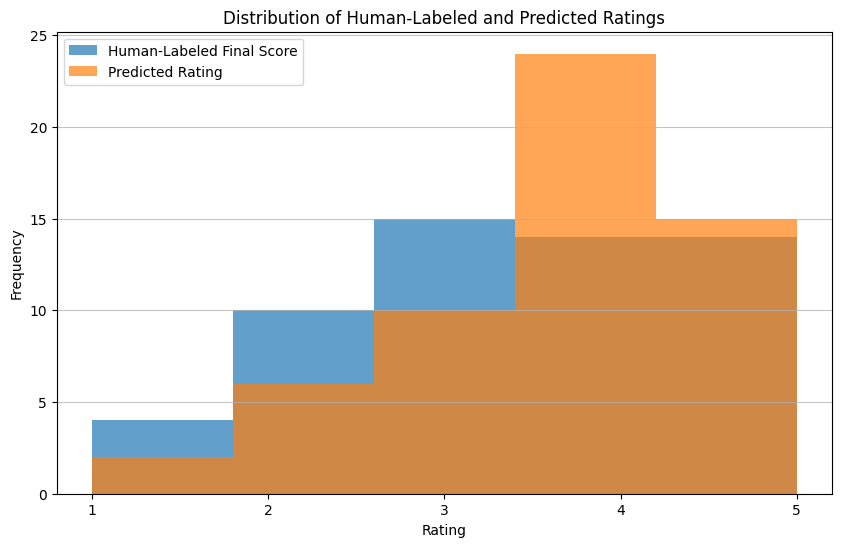

In [102]:
import matplotlib.pyplot as plt

# Plot histograms of Final Score and predicted_rating
plt.figure(figsize=(10, 6))
plt.hist(new_eval_df['Final Score'], bins=5, alpha=0.7, label='Human-Labeled Final Score', range=(1, 5))
plt.hist(new_eval_df['predictions1'].apply(lambda x: int(x['final_evaluation'].rating)), bins=5, alpha=0.7, label='Predicted Rating', range=(1, 5))
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Human-Labeled and Predicted Ratings')
plt.xticks(range(1, 6))
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

In [112]:
pred_cols = [f"predictions{i}" for i in range(1, 11)]
pred_ratings = new_eval_df[pred_cols].applymap(lambda x: x['final_evaluation'].rating)
avg_row_std = pred_ratings.std(axis=1, ddof=0).mean()
print("avg_row_std:", avg_row_std)

avg_row_std: 0.305453544507273


/tmp/ipython-input-2529343887.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pred_ratings = new_eval_df[pred_cols].applymap(lambda x: x['final_evaluation'].rating)


In [113]:
import numpy as np
mean_per_input = pred_ratings.mean(axis=1)
std_per_input  = pred_ratings.std(axis=1, ddof=0)   # population std (ddof=0). use ddof=1 if you prefer sample std
cv_per_input   = std_per_input / mean_per_input.replace(0, np.nan)  # avoid div-by-zero

# 2) Dataset-level summaries
summary = {
    'mean_CV': cv_per_input.mean(),                     # average CV across inputs
    'median_CV': cv_per_input.median(),
    'pct_inputs_CV_lt_10pct': (cv_per_input < 0.10).mean(),   # fraction meeting your <10% target
    'mean_rel_range': rel_range_per_input.mean(),
    'pct_exact_same_rating': (std_per_input == 0).mean(),     # proportion of inputs with zero variation
    'overall_CV': pred_ratings.stack().std(ddof=0) / pred_ratings.stack().mean(),  # global CV
}

# 3) Attach the per-input metrics to the dataframe (optional)
per_input_df = pd.DataFrame({
    'mean': mean_per_input,
    'std': std_per_input,
    'cv': cv_per_input,
    'rel_range': rel_range_per_input,
})

print("Dataset summary:", summary)
per_input_df.head()

Dataset summary: {'mean_CV': np.float64(0.09287983645114826), 'median_CV': 0.0967741935483871, 'pct_inputs_CV_lt_10pct': np.float64(0.5263157894736842), 'mean_rel_range': np.float64(0.25855115585826555), 'pct_exact_same_rating': np.float64(0.3333333333333333), 'overall_CV': np.float64(0.25855058000485864)}


,mean,std,cv,rel_range
3,2.4,0.489898,0.204124,0.416667
60,3.9,0.538516,0.138081,0.512821
59,5.0,0.000000,0.000000,0.000000
21,4.0,0.000000,0.000000,0.000000
24,3.9,0.300000,0.076923,0.256410


In [217]:
# Calculate the absolute difference between predicted and final scores
# Extract the rating from the 'predictions1' column (which contains the agentic model output)
new_eval_df['agentic_predicted_rating'] = new_eval_df['predictions1'].apply(lambda x: int(x['final_evaluation'].rating))

# Ensure the 'Final Score' column is numeric (it should be already, but good practice)
new_eval_df['Final Score'] = pd.to_numeric(new_eval_df['Final Score'])

# Calculate the absolute difference between the agentic predicted rating and the human-labeled Final Score
new_eval_df['rating_difference'] = abs(new_eval_df['agentic_predicted_rating'] - new_eval_df['Final Score'])

# Sort the DataFrame by the absolute difference in descending order
new_eval_df_sorted = new_eval_df.sort_values(by='rating_difference', ascending=False)

# Display the rows with the largest differences
# Include original English/Filipino, Final Score, agentic predicted rating, difference, and rater explanations
display(new_eval_df_sorted[['English', 'Filipino', 'Final Score', 'agentic_predicted_rating', 'rating_difference', 'Rater 1 Explanation', 'Rater 2 Explanation']])

,English,Filipino,Final Score,agentic_predicted_rating,rating_difference,Rater 1 Explanation,Rater 2 Explanation
3,Data normalization helps improve model perform...,Tumutulong sa pagpabuti ng model ang normalisa...,5.0,2,3.0,The translated text is natural and captures th...,The translation didn't literally translated th...
60,"The wave returns to the ocean, where it came f...","Bumabalik ang alon sa karagatan, kung saan ito...",2.0,5,3.0,The wording feels awkward and unnatural.,"Extremely unnatural wording, especially on ""ku..."
59,Mother died today. Or maybe yesterday; I can't...,Sumakabilang-buhay si Inay ngayong araw. O bak...,2.0,5,3.0,The tone in the translated text feels too coll...,Doesn't feel natural. Too literal.
21,Which of the following dental topics is develo...,Alin sa mga sumusunod na paksa sa ngipin ang a...,2.0,4,2.0,Most of the translation is actually quite spot...,"No direct translation for dental in tagalog, s..."
24,Sea of Thieves is a smash-hit pirate adventure...,Ang Sea of Thieves ay isang smash-hit na pirat...,2.0,4,2.0,"unnatural phrasing; ""quintessential na karanas...","stiff or overly formal tone, ""binagong edisyon..."
35,The kernel handles low-level operations in the...,Pinangangasiwaan ng kernel ang mga low-level n...,2.0,4,2.0,"A lot of English terms are retained, which is ...",\tPoor localization; relies too much on untran...
28,"For so long, you and me been finding each othe...","Matagal na, matagal na tayong dalawa naghahana...",2.0,4,2.0,translates you and me into tayo and the transl...,"You and me' was translated as 'tayo', which mi..."
15,"This guy right here is Shadow, and he's kinda ...","Ang lalaking ito dito ay si Shadow, at siya an...",1.0,3,2.0,"""Ang lalaking ito dito"" should not have ""dito""","buzz-kill is not translated. also ""totoong buz..."
63,That person has no more respect or love for yo...,Wala nang respeto at pagmamahal yung tao para ...,5.0,3,2.0,The sentence flows very well and uses more inf...,"Sounds very natural, capturing the sentiment c..."
38,Filipinos visit their relatives during holidays.,"Tuwing bakasyon, binibisita ng mga Pilipino an...",3.0,5,2.0,Better to use and phrase it as “Tuwing bakasyo...,- accurate translation\n- good grammar


In [215]:
# Filter new_eval_df to find rows where 'cultural_biases' type is 'Major'
major_cultural_biases_df = new_eval_df[
    new_eval_df['predictions1'].apply(
        lambda x: x['final_evaluation'].cultural_biases.type == 'Major'
    )
]

# Display the relevant columns for the filtered rows
tmp = major_cultural_biases_df.iloc[4]
print(tmp.English)
print(tmp.Filipino)
print(tmp.predictions1['final_evaluation'].cultural_biases)

Stealth is not your thing. But it's adorable you're willing to try.
Ang pagnanakaw ay hindi bagay sa iyo. Ngunit ito ay kaibig-ibig na handa kang subukan.
analysis='The mistranslation of stealth as pagnanakaw creates a significant cultural bias. The sentence could be perceived as accusatory or judgmental, depending on the context and relationship between the speakers. This introduces a negative and potentially offensive element that is absent in the original English sentence.' type='Major'


In [121]:
# Merge the two dataframes on English and Filipino columns
# Using an inner merge assumes that all rows in new_eval_df are also in eval_df
combined_eval_df = pd.merge(
    eval_df[['English', 'Filipino', 'predictions1']],
    new_eval_df[['English', 'Filipino', 'predictions1']],
    on=['English', 'Filipino'],
    how='inner',
    suffixes=('_prompt', '_agent')
)
combined_eval_df['abs_diff'] = abs(combined_eval_df['predictions1_prompt'].apply(lambda x: int(x.rating)) - combined_eval_df['predictions1_agent'].apply(lambda x: int(x['final_evaluation'].rating)))
# view sorted
combined_eval_df = combined_eval_df.sort_values(by='abs_diff', ascending=False)
combined_eval_df = combined_eval_df[combined_eval_df['abs_diff'] > 0]
combined_eval_df

,English,Filipino,predictions1_prompt,predictions1_agent,abs_diff
9,That designer bag costs an arm and a leg.,Napakamahal ng designer bag na 'yan.,"term_accuracy=Criteria(analysis=""The terms 'de...",{'final_evaluation': term_accuracy=Criteria(an...,2
14,This would be easier if blood came in more col...,Ito ay magiging mas madali kung ang dugo ay du...,"term_accuracy=Criteria(analysis=""The terms use...",{'final_evaluation': term_accuracy=Criteria(an...,2
33,Jollibee is a famous fast food restaurant in t...,Ang Jollibee ay isang sikat na kainan sa Pilip...,"term_accuracy=Criteria(analysis=""The terms 'Jo...",{'final_evaluation': term_accuracy=Criteria(an...,2
7,Thank you for coming to the event.,Salamat sa pagpunta sa kaganapan.,"term_accuracy=Criteria(analysis=""The terms 'Sa...",{'final_evaluation': term_accuracy=Criteria(an...,1
3,Data normalization helps improve model perform...,Tumutulong sa pagpabuti ng model ang normalisa...,"term_accuracy=Criteria(analysis=""The terms 'no...",{'final_evaluation': term_accuracy=Criteria(an...,1
16,Stealth is not your thing. But it's adorable y...,Ang pagnanakaw ay hindi bagay sa iyo. Ngunit i...,"term_accuracy=Criteria(analysis=""The term 'pag...",{'final_evaluation': term_accuracy=Criteria(an...,1
15,"This guy right here is Shadow, and he's kinda ...","Ang lalaking ito dito ay si Shadow, at siya an...","term_accuracy=Criteria(analysis=""The terms use...",{'final_evaluation': term_accuracy=Criteria(an...,1
6,The party of the first part shall not be held ...,Ang partido ng unang bahagi ay hindi mananagot...,"term_accuracy=Criteria(analysis=""All terms app...",{'final_evaluation': term_accuracy=Criteria(an...,1
5,It's raining cats and dogs.,Umuulan ng pusa at aso.,"term_accuracy=Criteria(analysis=""The terms 'um...",{'final_evaluation': term_accuracy=Criteria(an...,1
20,Which of the following dental topics is develo...,Alin sa mga sumusunod na paksa sa ngipin ang a...,"term_accuracy=Criteria(analysis=""All dental te...",{'final_evaluation': term_accuracy=Criteria(an...,1


In [189]:
i = 2
print(combined_eval_df.iloc[i].English)
print(combined_eval_df.iloc[i].Filipino)

Jollibee is a famous fast food restaurant in the Philippines.
Ang Jollibee ay isang sikat na kainan sa Pilipinas.


In [190]:
combined_eval_df.iloc[i].predictions1_prompt.model_dump()

{'term_accuracy': {'analysis': "The terms 'Jollibee', 'sikat' (famous), 'kainan' (restaurant), and 'Pilipinas' (Philippines) are all accurately translated.",
  'comment': 'No correction needed.',
  'type': 'Correct'},
 'meaning_fidelity': {'analysis': 'The translation accurately conveys the meaning of the source text.',
  'comment': 'No correction needed.',
  'type': 'Correct'},
 'grammar_structure': {'analysis': 'The grammar is correct and the sentence structure is natural.',
  'comment': 'No correction needed.',
  'type': 'Correct'},
 'style_naturalness': {'analysis': "The sentence sounds natural and is appropriate for a Filipino audience. The use of 'ay' is grammatically correct.",
  'comment': 'No correction needed.',
  'type': 'Correct'},
 'cultural_biases': {'analysis': 'The translation is culturally appropriate and does not contain any biases.',
  'comment': 'No correction needed.',
  'type': 'Correct'},
 'analysis': 'The translation is accurate, grammatically correct, and cultu

In [191]:
combined_eval_df.iloc[i].predictions1_agent['final_evaluation'].model_dump()

{'term_accuracy': {'analysis': '"Jollibee" is a proper noun and is correctly retained. "Fast food restaurant" is translated to "kainan," which is a general term for "eating place." While understandable, it lacks the specificity of the original.',
  'type': 'Minor'},
 'meaning_fidelity': {'analysis': 'The translation accurately conveys the information in the original sentence. There are no additions or omissions that significantly alter the meaning.',
  'type': 'Correct'},
 'grammar_structure': {'analysis': 'The Tagalog sentence follows correct grammatical structure. The use of "ay" as a linking verb is appropriate.',
  'type': 'Correct'},
 'style_naturalness': {'analysis': 'While grammatically correct, the sentence "Ang Jollibee ay isang sikat na kainan sa Pilipinas" can be improved for a more natural flow. A more common phrasing might be "Ang Jollibee ay isang sikat na kainan ng fast food sa Pilipinas" or "Sikat na kainan ng fast food sa Pilipinas ang Jollibee." The original translati